## **Is the rank of a tennis player associated with the amount of prize money they have won?** 


### **1. Introduction**:

For tennis players, rankings serve an important purpose, as they not only reflect the skill and performance of the player at the time but also determine which tournaments and sponsorships they get. There are many systems of rankings in the sport of men’s singles tennis. ATP rankings are based on the points earned by the players in official ATP-certified men’s singles or doubles events over the preceding 52-week time frame (Nag, 2021). The players’ best 19 tournaments played will be used to calculate their rank (Nag, 2021).

At large tennis tournaments, such as the US Open, prize money of up to $2, 500, 000 can be won by the winners (US Open, 2021). As such, we are examining whether the ATP ranking of a player can predict the amount of prize money the player has won in this study. We chose these two variables as the amount of prize money won is determined by the number of wins a player has. Since the ATP rank is based on how well a player performs at tournaments, we suspect a relationship between these two variables and since ATP ranking is so closely associated with how much prize money a player is able to receive through sponsorships and even their individual skill level, it would be an optimal predictor in regards to our analysis. In this study, we are examining whether the ATP ranking of a player is associated with the amount of prize money earned and then predicting the amount of money earned by a player from their ATP ranking. We will be using data acquired from www.ultimatetennisstatistics.com to answer our research question. This data is sourced from the open-source tennis data repository by Jeff Sackman.

### **2. Preliminary exploratory data analysis:**:


To load, modify, classify and plot data, we will use the package, 'tidyverse' and 'tidymodels' using the library function.

In [42]:
library(tidyverse)
library(scales)
library(tidymodels)

In [15]:

#First we will read the url into the notebook and use the make.names function to make names out of the character vectors in the data. 
#After doing this, we will select the columns tennisdata, Best.Rank, Prize.Money as these are the columns our analysis is based on. 
#Since the Prize.Money values are significantly larger, we will use the log10 function and use the na.omit function to eliminate 
#incomplete cases of our dataframe.
tennisdata <- read_csv("https://drive.google.com/uc?export=download&id=1_MECmUXZuuILYeEOfonSGqodW6qVdhsS")
cn = make.names(names(tennisdata))
colnames(tennisdata)<- cn
tennisdata2 <- select(tennisdata, Best.Rank, Prize.Money) %>%
mutate(Best.Rank = parse_number(gsub("\\s*\\([^\\)]+\\)","",as.character(Best.Rank))), 
       Prize.Money = log10(parse_number(Prize.Money))) %>%
na.omit()

Warning message:
“Missing column names filled in: 'X1' [1]”
Parsed with column specification:
cols(
  .default = col_character(),
  X1 = col_double(),
  `Turned Pro` = col_double(),
  Seasons = col_double(),
  Titles = col_double(),
  `Best Season` = col_double(),
  Retired = col_double(),
  Masters = col_double(),
  `Grand Slams` = col_double(),
  `Davis Cups` = col_double(),
  `Team Cups` = col_double(),
  Olympics = col_double(),
  `Weeks at No. 1` = col_double(),
  `Tour Finals` = col_double()
)

See spec(...) for full column specifications.



Now, we will partition tennisdata2 into a training and testing data set using tidymodels. Following the creation of these sets, we will use the training set to choose the right value of k and not use the testing set until then.

In [45]:
#To ensure that the result is reproducible, we will use the 'set.seed' function and set it to 031203. 
#After this, we will create the training and testing set using the 'initial_split' function to split 'tennisdata2'. 
#We will use 75% of the data and specify the variable we want to classify i.e 'Prize.Money' in the 'strata' argument.
set.seed(151103) # DO NOT CHANGE
tennis_split <- initial_split(tennisdata2, prop = 0.75, strata = Prize.Money)
tennis_training <- training(tennis_split)
tennis_testing <- testing(tennis_split)

print("Table 1: Training Data")
slice(tennis_training, 1:5)


[1] "Table 1: Training Data"


Best.Rank,Prize.Money
<dbl>,<dbl>
44,6.513426
130,5.572980
17,6.784758
213,5.445151
229,4.771756


To get more familiar with the training set, we will use the summary function. We can calculate the average value of both the variables and also the total number of rows in the training data

In [31]:
set.seed(031203) # DO NOT CHANGE
tennis_summary <- tennis_training %>%
summarise(Average_Rank = mean(Best.Rank, na.rm=TRUE), 
          Average_money = mean(Prize.Money, na.rm=TRUE),
          Total_Rows = n())
tennis_summary

Average_Rank,Average_money,Total_Rows
<dbl>,<dbl>,<int>
147.7175,5.713151,315


Next, we can visualize the data with which further allows us to get familiar with the data for our analysis.

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



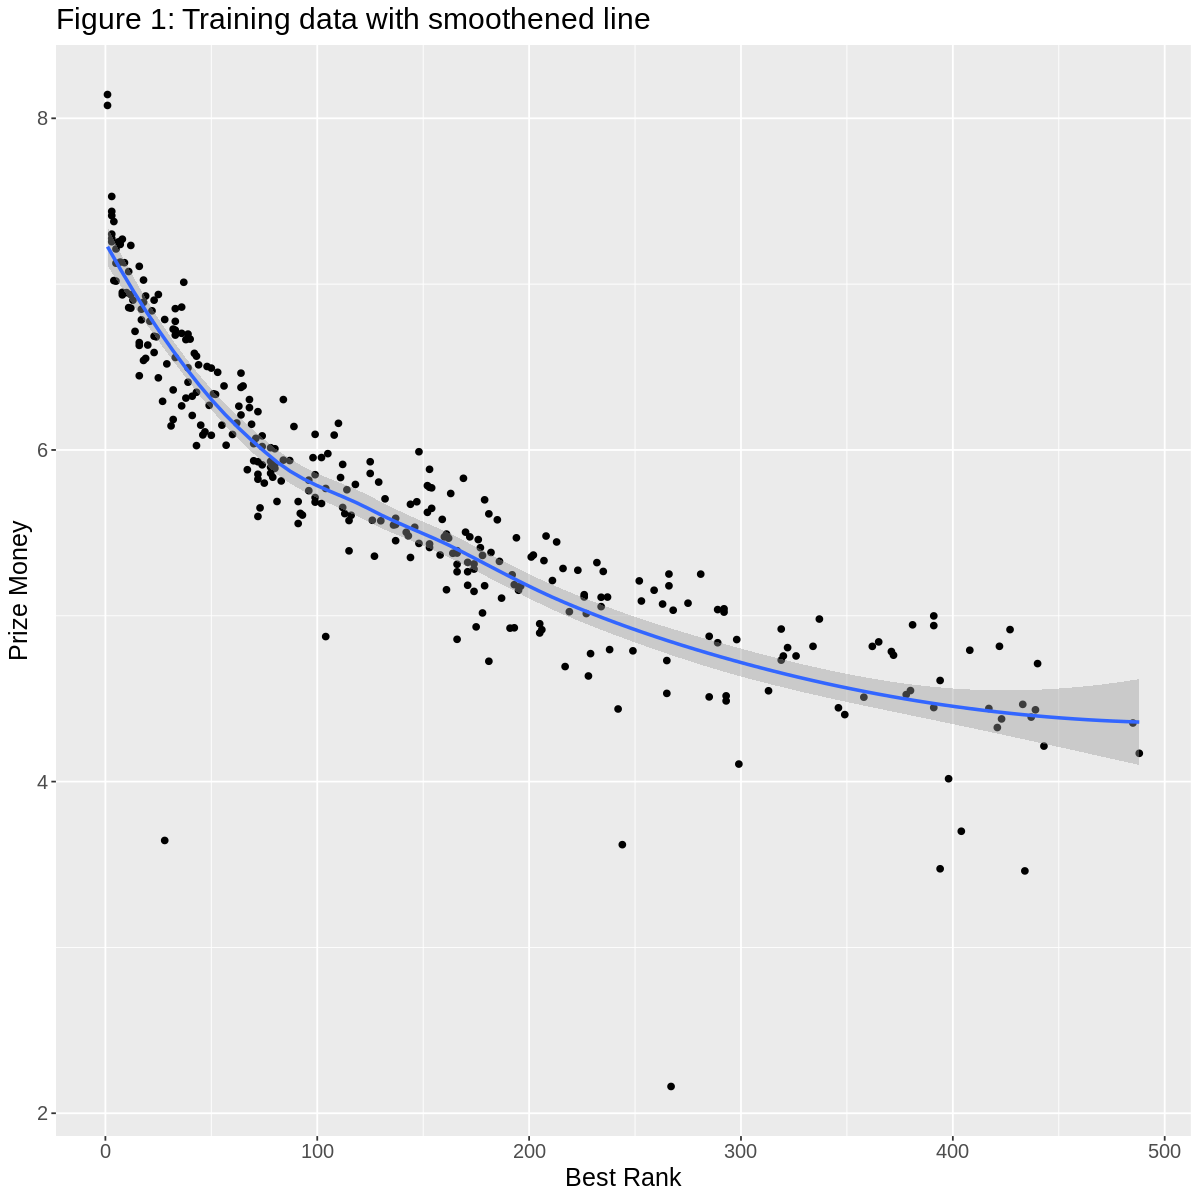

In [32]:
#Now we will create a scatterplot to visualise the relation of the Rank of Tennis Players against the Money they accumulate.
tennisplot <- tennis_training %>%
ggplot(aes(x = Best.Rank, y = Prize.Money)) +
geom_point() +
geom_smooth() +
labs(x = "Best Rank", y = "Prize Money") +
theme(text = element_text(size = 15)) +
ggtitle("Figure 1: Training data with smoothened line")
options(repr.plot.width = 10, repr.plot.height = 10)

tennisplot 

From this plot, we can see the general trend of the data between the predictor (Best Rank) and the predicted (Prize Money) variable. 

### **3. Methods**:
The key variables we are using are prize money won and the best ranking of the player. The ranking of the players is defined such that a high ranking represents a lower number, thus creating a downwards trend in our preliminary visualization. We can plot the data points of the Best Rank of a player as the value on the X-axis while the Prize Money received would be the value on the Y-axis. By plotting these points for every player that has both these values on record, we can create a graph that will allow us to see a possible relationship between these two variables. Once we do that, we will be conducting our data analysis using knn regression and try to predict the Prize Money gained by a player by just looking at their best rank. 


In [33]:
set.seed(031203) # DO NOT CHANGE
#First we can create a model and a recipe from the training data with Prize money as the predicted and Best Rank as the predictor variable
tennis_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>% 
       set_engine("kknn") %>%
       set_mode("regression") 

tennis_recipe <- recipe(Prize.Money ~ Best.Rank, data = tennis_training) %>%
       step_scale(all_predictors()) %>%
       step_center(all_predictors())

tennis_recipe

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor          1

Operations:

Scaling for all_predictors()
Centering for all_predictors()

In [34]:
set.seed(031203) # DO NOT CHANGE
#Next we can perform a 5 fold cross validation in order to find the ideal number of neighbour for our k nearest neighbours analysis
tennis_vfold <- vfold_cv(tennis_training, v = 5, strata = Prize.Money)
tennis_workflow <- workflow() %>%
       add_recipe(tennis_recipe) %>%
       add_model(tennis_spec) 


tennis_workflow

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_scale()
● step_center()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [47]:
set.seed(031203) # DO NOT CHANGE
gridvals <- tibble(neighbors = seq(1, 200))

tennis_results <- tennis_workflow %>%
       tune_grid(resamples = tennis_vfold, grid = gridvals) %>%
collect_metrics()

print("Table 2: VFold Results")
head(tennis_results)

[1] "Table 2: VFold Results"


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,0.4821199,5,0.06287781,Model001
1,rsq,standard,0.7132919,5,0.06929414,Model001
2,rmse,standard,0.3919267,5,0.05894334,Model002
2,rsq,standard,0.8061030,5,0.04459108,Model002
3,rmse,standard,0.3754554,5,0.05915901,Model003
3,rsq,standard,0.8205605,5,0.04371907,Model003


In [48]:
#Here we can arrange the table in ascending order of the rsme to find the number of neighbours with the least rmse
tennis_min <- tennis_results %>%
    filter(.metric == "rmse") %>%
    arrange(mean) %>% 
    slice(1) 
print("Table 3: Minimum RMSE")
tennis_min

[1] "Table 3: Minimum RMSE"


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
19,rmse,standard,0.3279922,5,0.06717756,Model019


In [49]:
#k_min is the ideal number of neighbours
k_min <- tennis_min %>%
          pull(neighbors)

#using it we can create the best model
tennis_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) %>%
          set_engine("kknn") %>%
          set_mode("regression")

#then create a new workflow that incorporates the new model
tennis_best_fit <- workflow() %>%
          add_recipe(tennis_recipe) %>%
          add_model(tennis_best_spec) %>%
          fit(data = tennis_training)

#finally we can predict the prize money from the training data and view the metrics
tennis_summary <- tennis_best_fit %>%
           predict(tennis_testing) %>%
           bind_cols(tennis_testing) %>%
           metrics(truth = Prize.Money, estimate = .pred)

print("Table 4: Predictions Summary")
tennis_summary

[1] "Table 4: Predictions Summary"


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,0.2756185
rsq,standard,0.8919320
mae,standard,0.2108949


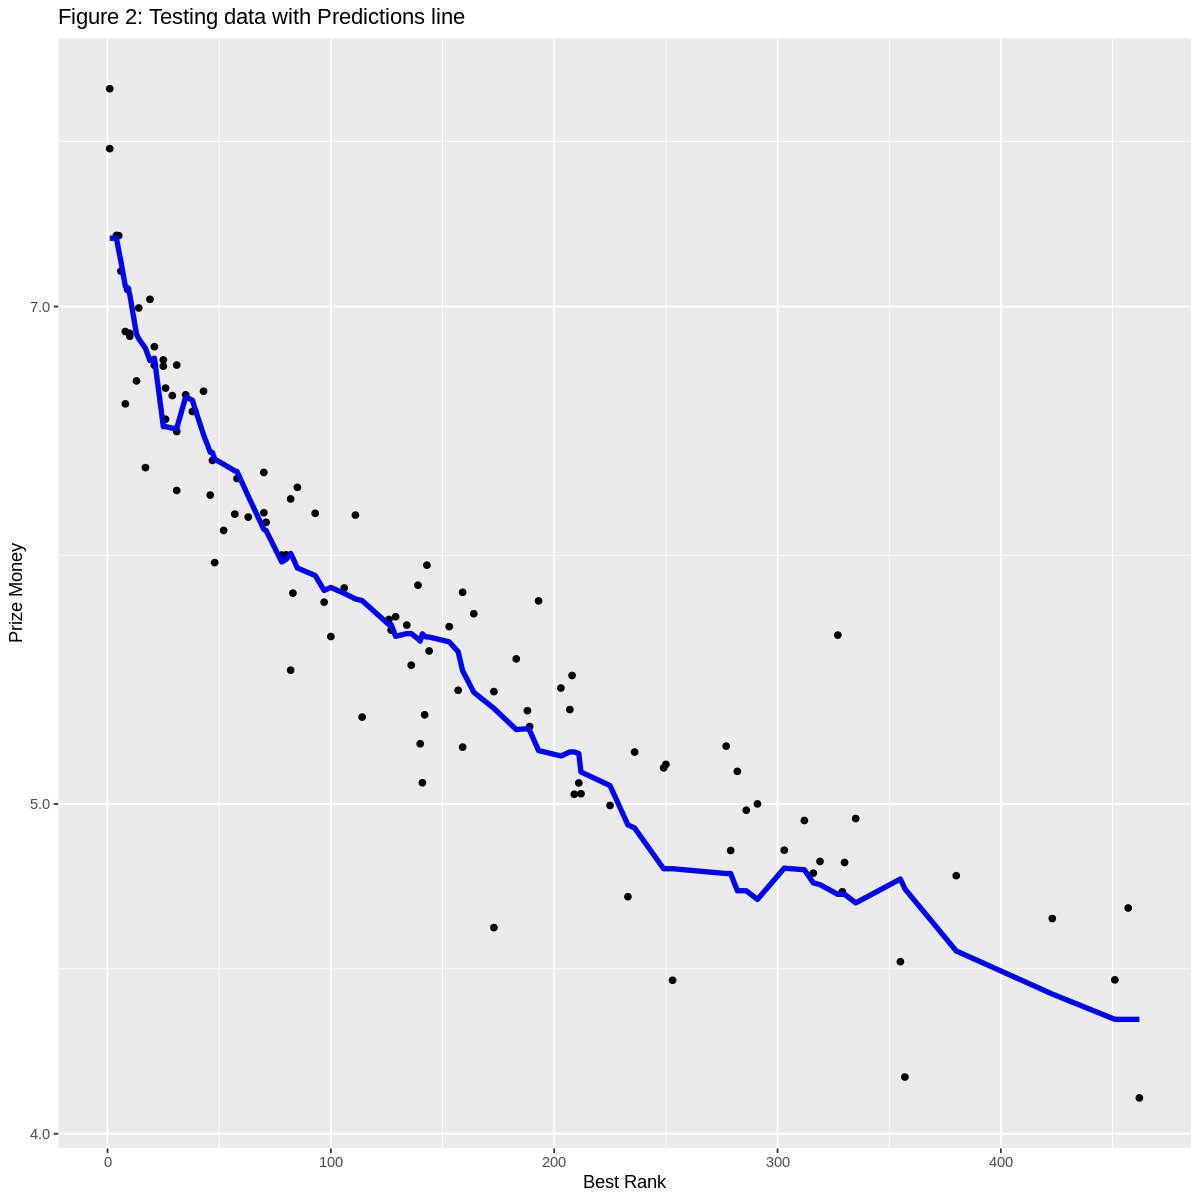

In [38]:
#To view our findings, we can create a plot with 
tennis_predsmid <- predict(tennis_best_fit, tennis_testing) 
tennis_preds <- tennis_testing %>%
                    bind_cols(tennis_predsmid)
tennis_plot <- ggplot(tennis_preds, aes(x = Best.Rank, y = Prize.Money))+
       geom_point() +
       geom_line(aes(x = Best.Rank, y = .pred), color = "blue", size = 1.5) +
       labs(x = "Best Rank", y = "Prize Money", title = "Prize Money Predictions") +
scale_y_log10(labels = label_comma())+
ggtitle("Figure 2: Testing data with Predictions line")
                 
tennis_plot

### **4. Discussion**: 
In our proposal, we predicted that the higher the rank of the player, the higher the amount of prize money will be won, due to the downward trend we have observed between player rank and the amount of prize money earned. Our prediction was correct and expected, as seen in the downwards curve in the final scatterplot, captured with the KNN line. We chose K = 13 as it has the smallest RMSE. The line appears to follow the overall trend well, and since it does not really follow the fluctuations or “noise” we can confidently transfer our generalization to future data.
The impact of these findings is useful for predicting the earnings of professional players, which is useful information for organizations like sports networks or even financial management companies. Future questions this study can lead to can include examining mediators that lead to this association, such as factoring predictors like the age of the player, their socioeconomic status growing up and the country they are from. Additionally, the impact of the COVID-19 pandemic has had implications for many athletes, especially tennis players when training and tournaments all came to a halt (Šimić, 2021; Washif et al., 2021). Another consequence of the pandemic includes the decrease in prize money in the post-lockdown age due to the economic recession of 2020 (Šimić, 2021). Building on our results, it would be interesting to explore the impact of income loss on these players as well as any effects the lockdown-mediated changes in training has had on a player’s ATP rank post-lockdown.

## Works Cited
* Nag, U. (2021, February 23). Tennis rankings: How they work and difference between ATP and WTA Systems. Tennis rankings: Everything you need to know. Retrieved November 9, 2021, from https://olympics.com/en/featured-news/tennis-rankings-atp-wta-men-women-doubles-singles-system-grand-slam-olympics. 
* Šimić, V. (2021). Prize money earnings of tennis professionals and the impact of COVID-19 pandemic. International Journal of Business and Economic Sciences Applied Research, 14(1), 47-57. https://doi.org/10.25103/ijbesar.141.04 * US Open. (2021, September 12). Prize Money. Usopen.org. Retrieved November 9, 2021, from https://www.usopen.org/en_US/visit/prize_money.html.  * Washif, J. A., Farooq, A., Krug, I., Pyne, D. B., Verhagen, E., Taylor, L., Wong, D. P., Mujika, I., Cortis, C., Haddad, M., Ahmadian, O., Al Jufaili, M., Al-Horani, R. A., Al-Mohannadi, A. S., Aloui, A., Ammar, A., Arifi, F., Aziz, A. R., Batuev, M., . . . Chamari, K. (2021). Training during the COVID-19 lockdown: Knowledge, beliefs, and practices of 12,526 athletes from 142 countries and six continents. Sports Medicine (Auckland), https://doi.org/10.1007/s40279-021-01573-z 